# VeloceReduction -- Tutorial

This tutorial provides an example on how to reduce data of a given night YYMMDD.

In [1]:
# Preamble
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic packages
import numpy as np
from astropy.io import fits
from pathlib import Path
import sys
import argparse

import matplotlib.pyplot as plt

# VeloceReduction modules and function
from VeloceReduction import config
import VeloceReduction as VR

## Adjust Date and Directory (possibly via argument parser)

In [2]:
def parse_arguments():
    # Create the parser
    parser = argparse.ArgumentParser(description="Process some inputs.")
    
    # Add arguments
    parser.add_argument('-d','--date', type=str, default="001122",
                        help='Date in the format DDMMYY (e.g., "001122")')
    parser.add_argument('-wd','--working_directory', type=str, default="./",
                        help='The directory where the script will operate.')
    
    # Parse the arguments
    args = parser.parse_args()
    return args

def get_script_input():
    if 'ipykernel' in sys.modules:
        
        # Assume default values if inside Jupyter
        jupyter_date = "001122"
        
        # 2Amp example
#         jupyter_date = "240219"
        
        # 4Amp example
#         jupyter_date = "231121"
        
#         jupyter_date = "240201"
        
        jupyter_working_directory = "./"
        print("Running in a Jupyter notebook. Using predefined values")
        args = argparse.Namespace(date=jupyter_date, working_directory=jupyter_working_directory)
    else:
        # Use argparse to handle command-line arguments
        print("Running as a standalone Python script")
        args = parse_arguments()

    return args

# Use the function to get input
args = get_script_input()
config.date = args.date
config.working_directory = args.working_directory
print(f"Date: {args.date}, Working Directory: {args.working_directory}")

Running in a Jupyter notebook. Using predefined values
Date: 001122, Working Directory: ./


## Identfiy Calibration and Science Runs

In [3]:
# Extract the Calibration and Science data from the night log
calibration_runs, science_runs = VR.utils.identify_calibration_and_science_runs(config.date, config.working_directory+'observations/')



Identifying calibration and science runs now

Found Log file ./observations//001122/001122-AAT-example.log


No Bstar observations were identified.

The following science observations were identified: HIP69673


## Extract orders and save in initial FITS files with an extension per order.

In [4]:
# Extract initial order ranges and coefficients
initial_order_ranges, initial_order_coeffs = VR.extraction.extract_initial_order_ranges_and_coeffs()

In [5]:
# # Extract Master Flat
# print('Extracting Master Flat')
# master_flat, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['Flat_60.0'][:1],
#     ccd2_runs = calibration_runs['Flat_1.0'][:1],
#     ccd3_runs = calibration_runs['Flat_0.1'][:1],
#     Flat = True,
#     #debug_overscan=True
# )

# # Extract Master ThXe
# print('Extracting Master ThXe')
# master_thxe, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['FibTh_180.0'][:1],
#     ccd2_runs = calibration_runs['FibTh_60.0'][:1],
#     ccd3_runs = calibration_runs['FibTh_15.0'][:1]
# )

# # Extract Master LC
# print('Extracting Master LC')
# master_lc, noise = VR.extraction.extract_orders(
#     ccd1_runs = calibration_runs['SimLC'][-1:],
#     ccd2_runs = calibration_runs['SimLC'][-1:],
#     ccd3_runs = calibration_runs['SimLC'][-1:],
#     LC = True,
#     # tramline_debug = True
# )

In [6]:
# # Extract Science Objects and save them into FITS files under reduced_data/
# for science_object in list(science_runs.keys()):
#     print('Extracting '+science_object)
#     try:
#         science, science_noise, science_header = VR.extraction.extract_orders(
#             ccd1_runs = science_runs[science_object],
#             ccd2_runs = science_runs[science_object],
#             ccd3_runs = science_runs[science_object],
#             Science=True,
#             #debug_overscan=True
#         )

#         # Create a primary HDU and HDU list
#         primary_hdu = fits.PrimaryHDU()
#         header = primary_hdu.header
#         header['OBJECT']             = (science_header['OBJECT'], 'Name of observed object in night log')
#         header['HIERARCH SOURCE_ID'] = (-1,                       'Gaia DR3 source_id')
#         header['HIERARCH TMASS_ID']  = ('HHMMSSSS-DDMMSSS',       'Identifier in 2MASS catalog')
#         header['UTMJD']              = (science_header['UTMJD'],  'Modified Julian Date of observation')
#         header['MEANRA']             = (science_header['MEANRA'], 'Mean Right Ascension of observed object')
#         header['MEANDEC']            = (science_header['MEANDEC'],'Mean Declination of observed object')        
#         header['BARYVEL']            = ('None',                   'Applied barycentric velocity correction')
#         header['VRAD']               = ('None',                   'Radial velocity estimate')
#         header['E_VRAD']             = ('None',                   'Uncertainty of radial velocity estimate')
#         hdul = fits.HDUList([primary_hdu])

#         # Loop over your extension names and corresponding data arrays
#         for ext_index, ext_name in enumerate(initial_order_coeffs):
#             # Create an ImageHDU object for each extension
            
#             # Apply flat-field calibration to science
#             science[ext_index,:] /= master_flat[ext_index,:]
#             science_noise[ext_index,:] /= master_flat[ext_index,:]
            
#             # Apply rough renormalisation with outlier-robuster 99th percenile
#             science_99percentile = np.nanpercentile(science[ext_index,:],q=99)
#             science[ext_index,:] /= science_99percentile
#             science_noise[ext_index,:] /= science_99percentile            
            
#             # Define the columns with appropriate formats
#             col1_def = fits.Column(name='wave_vac',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col2_def = fits.Column(name='wave_air',format='E', array=np.arange(len(science[ext_index,:]),dtype=float))
#             col3_def = fits.Column(name='science', format='E', array=science[ext_index,:])
#             col4_def = fits.Column(name='science_noise',   format='E', array=science_noise[ext_index,:])
#             col5_def = fits.Column(name='flat',    format='E', array=master_flat[ext_index,:])
#             col6_def = fits.Column(name='thxe',    format='E', array=master_thxe[ext_index,:]/master_flat[ext_index,:])
#             col7_def = fits.Column(name='lc',      format='E', array=master_lc[ext_index,:]/master_flat[ext_index,:])

#             # Combine columns to BinTable and add header from primary
#             hdu = fits.BinTableHDU.from_columns([col1_def, col2_def, col3_def, col4_def, col5_def, col6_def, col7_def], name=ext_name.lower())
#             hdu.header.extend(header.copy(strip=True), unique=True)
            
#             # Append the HDU to the HDU list
#             hdul.append(hdu)

#         # Save to a new FITS file with an extension for each order
#         Path(config.working_directory+'reduced_data/'+config.date+'/'+science_object).mkdir(parents=True, exist_ok=True)
#         spectrum_filename = 'veloce_spectra_'+science_object+'_'+config.date+'.fits'
#         hdul.writeto(config.working_directory+'reduced_data/'+config.date+'/'+science_object+'/'+spectrum_filename, overwrite=True)

#         print('  -> Successfully extracted '+science_object)

#     except:
#         print('  -> Failed to extract '+science_object)

## Wavelength calibration

In [7]:
# for science_object in list(science_runs.keys()):
#     try:
#         VR.calibration.calibrate_wavelength(science_object, correct_barycentric_velocity=True, create_overview_pdf=True)
#         print('  -> Succesfully calibrated wavelength with diagnostic plots for '+science_object)
#     except:
#         print('  -> Failed to calibrate wavelength for '+science_object)

### DELETE WHEN DONE: UPDATE TRAMLINE EXTRACTION!

In [8]:
thxe_images = dict()

ccd1_runs = calibration_runs['FibTh_180.0'][:1]
ccd2_runs = calibration_runs['FibTh_60.0'][:1]
ccd3_runs = calibration_runs['FibTh_15.0'][:1]

for ccd in [1,2,3]:
    thxe_images['ccd_'+str(ccd)] = []
    if ccd == 1: runs = ccd1_runs
    if ccd == 2: runs = ccd2_runs
    if ccd == 3: runs = ccd3_runs

    for run in runs:
        full_image, metadata = VR.utils.read_veloce_fits_image_and_metadata(config.working_directory+'observations/'+config.date+'/ccd_'+str(ccd)+'/'+config.date[-2:]+VR.utils.match_month_to_date(config.date)+str(ccd)+run+'.fits')
        trimmed_image, os_median, os_rms, readout_mode = VR.extraction.substract_overscan(full_image, metadata)
        thxe_images['ccd_'+str(ccd)].append(trimmed_image)
        thxe_images['ccd_'+str(ccd)] = np.array(np.median(thxe_images['ccd_'+str(ccd)],axis=0),dtype=float)

In [9]:
images = dict()

ccd1_runs = calibration_runs['Flat_60.0'][:1]
ccd2_runs = calibration_runs['Flat_1.0'][:1]
ccd3_runs = calibration_runs['Flat_0.1'][:1]

for ccd in [1,2,3]:
    images['ccd_'+str(ccd)] = []
    if ccd == 1: runs = ccd1_runs
    if ccd == 2: runs = ccd2_runs
    if ccd == 3: runs = ccd3_runs

    for run in runs:
        full_image, metadata = VR.utils.read_veloce_fits_image_and_metadata(config.working_directory+'observations/'+config.date+'/ccd_'+str(ccd)+'/'+config.date[-2:]+VR.utils.match_month_to_date(config.date)+str(ccd)+run+'.fits')
        trimmed_image, os_median, os_rms, readout_mode = VR.extraction.substract_overscan(full_image, metadata)
        images['ccd_'+str(ccd)].append(trimmed_image)
        images['ccd_'+str(ccd)] = np.array(np.median(images['ccd_'+str(ccd)],axis=0),dtype=float)

In [10]:
lc_image = dict()

ccd1_runs = calibration_runs['SimLC'][-1:]
ccd2_runs = calibration_runs['SimLC'][-1:]
ccd3_runs = calibration_runs['SimLC'][-1:]

for ccd in [1,2,3]:
    lc_image['ccd_'+str(ccd)] = []
    if ccd == 1: runs = ccd1_runs
    if ccd == 2: runs = ccd2_runs
    if ccd == 3: runs = ccd3_runs

    for run in runs:
        full_image, metadata = VR.utils.read_veloce_fits_image_and_metadata(config.working_directory+'observations/'+config.date+'/ccd_'+str(ccd)+'/'+config.date[-2:]+VR.utils.match_month_to_date(config.date)+str(ccd)+run+'.fits')
        trimmed_image, os_median, os_rms, readout_mode = VR.extraction.substract_overscan(full_image, metadata)
        lc_image['ccd_'+str(ccd)].append(trimmed_image)
        lc_image['ccd_'+str(ccd)] = np.array(np.median(lc_image['ccd_'+str(ccd)],axis=0),dtype=float)

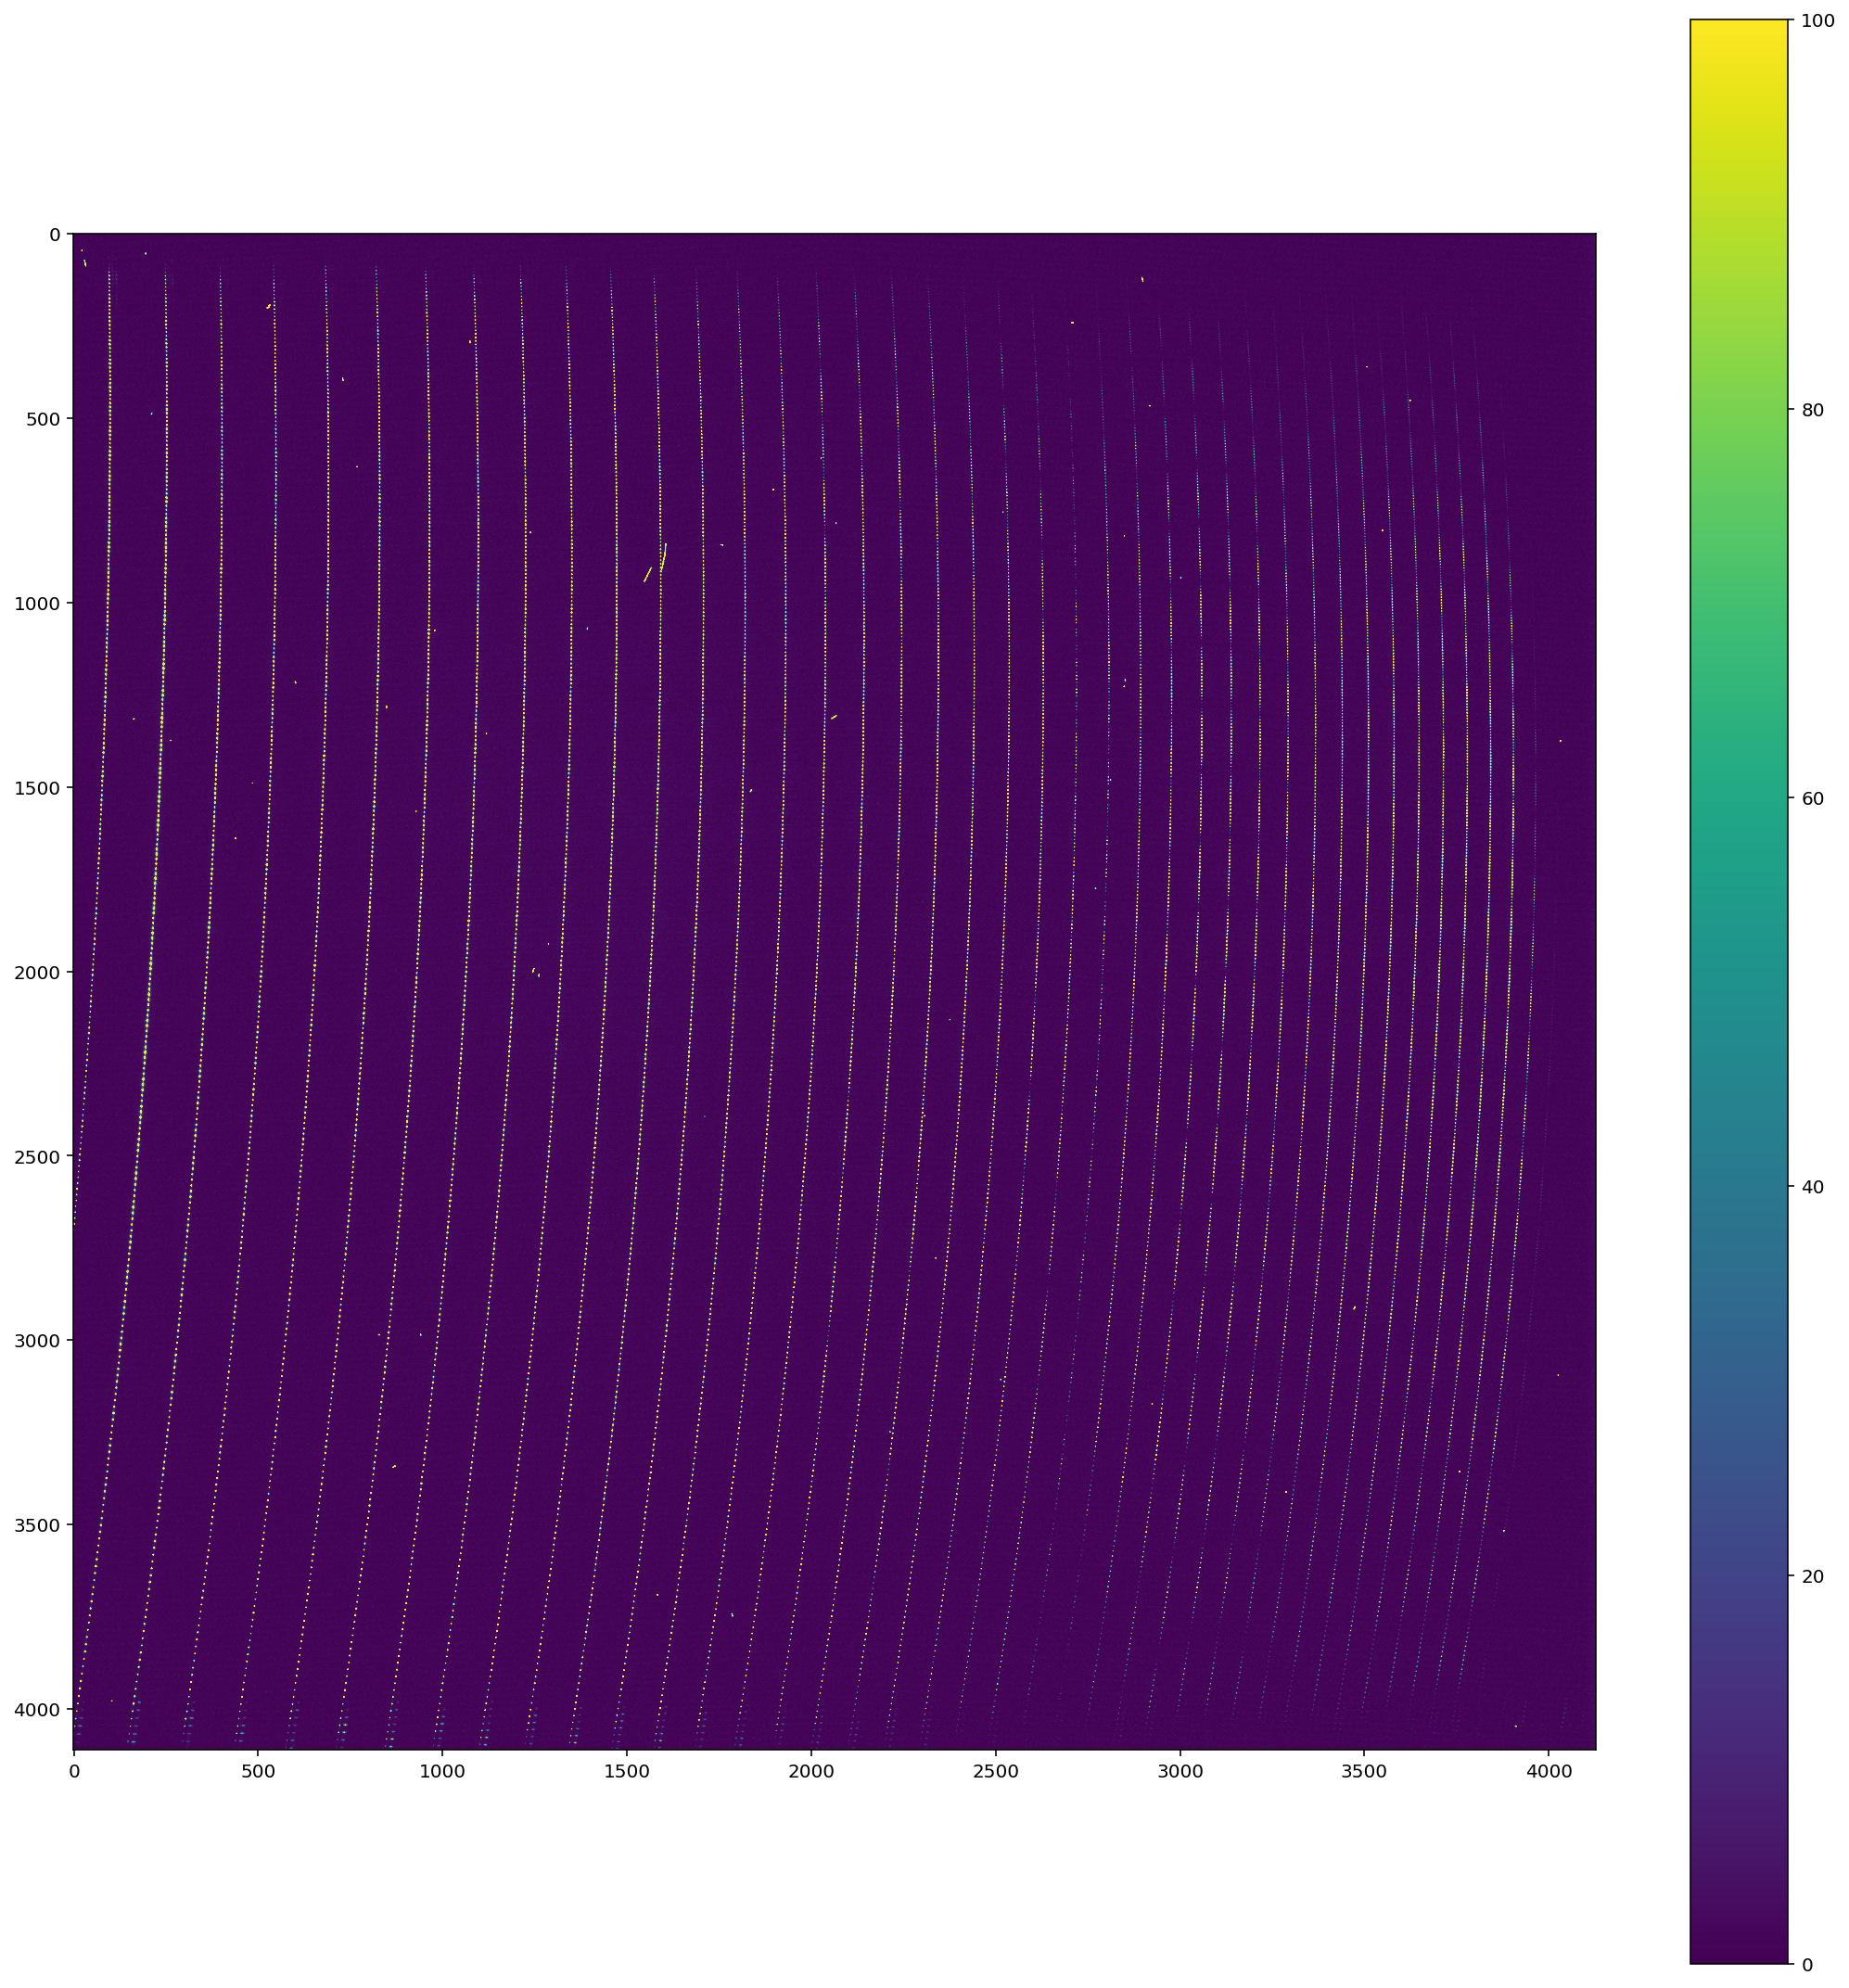

In [11]:
f, ax = plt.subplots(figsize=(15,15))
s = ax.imshow(lc_image['ccd_3'],vmax=100)
plt.colorbar(s,ax=ax)
plt.tight_layout()
plt.show()
plt.close()

In [12]:
# for order in initial_order_coeffs:
#     if order[4] == '3': print("buffer['"+order+"'] = 105")

In [13]:
# Active code  

# LC = False
# debug_tramlines = True

# for ccd in ['3']:#['1','2','3']:

#     for order in initial_order_coeffs:
# #
# #         if (ccd == order[4]) & (int(order[-2:]) > 10) & (int(order[-2:]) < 93):
# #         if ccd == order[4]:
#         if order in ['ccd_3_order_96']:
        
#         def optimise_tramline_polynomial(image, order)
        
            
        
#             print(order, buffer[order])

#             buffer = dict()
#             buffer['ccd_3_order_65'] = [105,50]
#             buffer['ccd_3_order_66'] = [105,50]
#             buffer['ccd_3_order_67'] = [105,50]
#             buffer['ccd_3_order_68'] = [105,50]
#             buffer['ccd_3_order_69'] = [105,50]
#             buffer['ccd_3_order_70'] = [105,50]
#             buffer['ccd_3_order_71'] = [105,50]
#             buffer['ccd_3_order_72'] = [105,50]
#             buffer['ccd_3_order_73'] = [105,50]
#             buffer['ccd_3_order_74'] = [105,50]
#             buffer['ccd_3_order_75'] = [105,50]
#             buffer['ccd_3_order_76'] = [105,50]
#             buffer['ccd_3_order_77'] = [105,50]
#             buffer['ccd_3_order_78'] = [105,50]
#             buffer['ccd_3_order_79'] = [105,50]
#             buffer['ccd_3_order_80'] = [105,50]
#             buffer['ccd_3_order_81'] = [105,50]
#             buffer['ccd_3_order_82'] = [105,50]
#             buffer['ccd_3_order_83'] = [115,50]
#             buffer['ccd_3_order_84'] = [115,50]
#             buffer['ccd_3_order_85'] = [130,50]
#             buffer['ccd_3_order_86'] = [135,50]
#             buffer['ccd_3_order_87'] = [135,50]
#             buffer['ccd_3_order_88'] = [155,100]
#             buffer['ccd_3_order_89'] = [190,100]
#             buffer['ccd_3_order_90'] = [230,100]
#             buffer['ccd_3_order_91'] = [230,100]
#             buffer['ccd_3_order_92'] = [300,100]
#             buffer['ccd_3_order_93'] = [310,100]
#             buffer['ccd_3_order_94'] = [330,125]
#             buffer['ccd_3_order_95'] = [350,125]
#             buffer['ccd_3_order_96'] = [370,125]
#             buffer['ccd_3_order_97'] = [360,125]
#             buffer['ccd_3_order_98'] = [410,125]
#             buffer['ccd_3_order_99'] = [370,150]
#             buffer['ccd_3_order_100'] = [375,150]
#             buffer['ccd_3_order_101'] = [580,150]
#             buffer['ccd_3_order_102'] = [400,150]
#             buffer['ccd_3_order_103'] = [710,150]
#             buffer['ccd_3_order_104'] = [1600,150]


#             adjusted_order_pixel = []
#             adjusted_order_beginning = []
#             adjusted_order_ending = []

#             image_dimensions = np.shape(images['ccd_'+str(ccd)])

#             # Identify the rough (too wide) tramline ranges for each order
#             # initial_order_ranges[order] are the initial orders reported by C.Tinney with slight adjustments.
#             initial_order_ranges, initial_order_coeffs = VR.extraction.extract_initial_order_ranges_and_coeffs()

#             left = -65
#             right = 10
#             if LC & (ccd == '3'):
#                 left = 0
#                 right = 10
#             if LC & (ccd == '2'):
#                 left = 8
#                 right = 20

#             order_xrange_begin = np.array(VR.utils.polynomial_function(np.arange(np.shape(images['ccd_'+str(ccd)])[0]),*initial_order_coeffs[order])+left,dtype=int)
#             order_xrange_end   = np.array(VR.utils.polynomial_function(np.arange(np.shape(images['ccd_'+str(ccd)])[0]),*initial_order_coeffs[order])+right,dtype=int)

#             f, ax = plt.subplots(figsize=(15,15))
#             ax.set_title(order)
#             ax.imshow(np.log10(images['ccd_'+str(ccd)]),cmap='Greys')
#             ax.plot(order_xrange_begin,np.arange(len(order_xrange_begin)),c='C3',lw=0.5)
#             ax.plot(order_xrange_end,np.arange(len(order_xrange_begin)),c='C3',lw=0.5)
#             ax.axhline(buffer[order][0])
#             ax.axhline(image_dimensions[0]-buffer[order][1])
#             ax.set_aspect(1/10)

#             # Because of the extended overscan region in 4Amplifier readout mode, we have to adjust which region we are using the extract the orders from.
#             if readout_mode == '2Amp':
#                 order_ranges_adjusted_for_readout_mode = initial_order_ranges[order]
#             elif readout_mode == '4Amp':
#                 order_ranges_adjusted_for_readout_mode = initial_order_ranges[order][16:-16]
#             else:
#                 raise ValueError('Cannot handle readout_mode other than 2Amp or 4Amp')

#             order_ranges_adjusted_for_readout_mode = np.arange(image_dimensions[0])

#             for x_index, x in enumerate(order_ranges_adjusted_for_readout_mode):

#                 # The uppermost and lowermost ~100 pixels typically do no get a lot of exposure
#                 # For robustness, let's neglect these pixels
#                 if (x_index >= buffer[order][0]) & (x_index <= image_dimensions[0] - buffer[order][1]):
#                     x_pixels_to_be_tested_for_tramline = np.arange(order_xrange_begin[x_index],order_xrange_end[x_index])
#                     x_pixels_to_be_tested_for_tramline = x_pixels_to_be_tested_for_tramline[x_pixels_to_be_tested_for_tramline >= 0]
#                     x_pixel_values_to_be_tested_for_tramline = images['ccd_'+str(ccd)][x,x_pixels_to_be_tested_for_tramline]

#                     if len(x_pixel_values_to_be_tested_for_tramline) > 0:

#                         # We assume that flat measurements should be ~50% of the maximum
#                         threshold = 0.5*np.nanmax(x_pixel_values_to_be_tested_for_tramline)
#                         above_threshold = np.where(x_pixel_values_to_be_tested_for_tramline > threshold)[0]

#                         if x_index == buffer[order][0]:
#                             tramline_beginning = np.nan
#                             tramline_ending = np.nan
#                         tramline_beginning, tramline_ending = VR.extraction.find_tramline_beginning_and_ending(
#                             x_pixels_to_be_tested_for_tramline[above_threshold],
#                             previous_beginning = tramline_beginning,
#                             previous_ending = tramline_ending
#                         )

#                         x_pixels_tramline = []
#                         if np.isfinite(tramline_beginning) & np.isfinite(tramline_ending):
#                             x_pixels_tramline = np.arange(tramline_beginning,tramline_ending)
#                             adjusted_order_pixel.append(x_index)
#                             adjusted_order_beginning.append(tramline_beginning)
#                             adjusted_order_ending.append(tramline_ending)

#             adjusted_order_pixel     = np.array(adjusted_order_pixel)
#             adjusted_order_beginning = np.array(adjusted_order_beginning)
#             adjusted_order_ending    = np.array(adjusted_order_ending)
            
#             order_beginning_fit = curve_fit(
#                 VR.utils.polynomial_function,
#                 adjusted_order_pixel,
#                 adjusted_order_beginning,
#                 p0 = [np.median(adjusted_order_beginning),0,0,0,0]
#             )[0]
#             order_ending_fit = curve_fit(
#                 VR.utils.polynomial_function,
#                 adjusted_order_pixel,
#                 adjusted_order_ending,
#                 p0 = [np.median(adjusted_order_ending),0,0,0,0]
#             )[0]
            
#             np.savetxt('VeloceReduction/tramline_information/tramlines_begin_end_'+order+'.txt',
#                       np.array([
#                           ['#c0', 'c1', 'c2', 'c3', 'c4','buffer_pixel'],
#                           np.concatenate((order_beginning_fit,[buffer[order][0]])),
#                           np.concatenate((order_ending_fit,[buffer[order][1]]))
#                       ]),
#                       fmt='%s')
            
#             np.loadtxt
            
#             ax.plot(
#                 adjusted_order_beginning,
#                 adjusted_order_pixel,
#                 c = 'C1'
#             )
#             ax.plot(
#                 np.round(VR.utils.polynomial_function(np.arange(image_dimensions[0]), *order_beginning_fit),0),
#                 np.arange(image_dimensions[0]),
#                 c = 'C0',
#                 ls = 'dashed'
#             )
#             ax.plot(
#                 adjusted_order_ending,
#                 adjusted_order_pixel,
#                 c = 'C1'
#             )
#             ax.plot(
#                 np.round(VR.utils.polynomial_function(np.arange(image_dimensions[0]), *order_ending_fit),0),
#                 np.arange(image_dimensions[0]),
#                 c = 'C0',
#                 ls = 'dashed'
#             )
#             try:
#                 ax.set_xlim(np.nanmin(adjusted_order_beginning) - 20, np.nanmax(adjusted_order_ending) + 20)
#             except:
#                 pass

#             plt.show()
#             plt.close()


Old vs New:
Buffer:
[370.0, 125.0] [370, 125]
Beginning:
[ 3.33236757e+03  8.98744525e-02 -3.50559445e-05  1.21486122e-09
 -1.45449906e-13] [ 3.33236757e+03  8.98744525e-02 -3.50559445e-05  1.21486122e-09
 -1.45449906e-13]
Ending:
[ 3.37160133e+03  8.85545107e-02 -3.40793341e-05  9.33694456e-10
 -1.17804079e-13] [ 3.37160133e+03  8.85545107e-02 -3.40793341e-05  9.33694456e-10
 -1.17804079e-13]


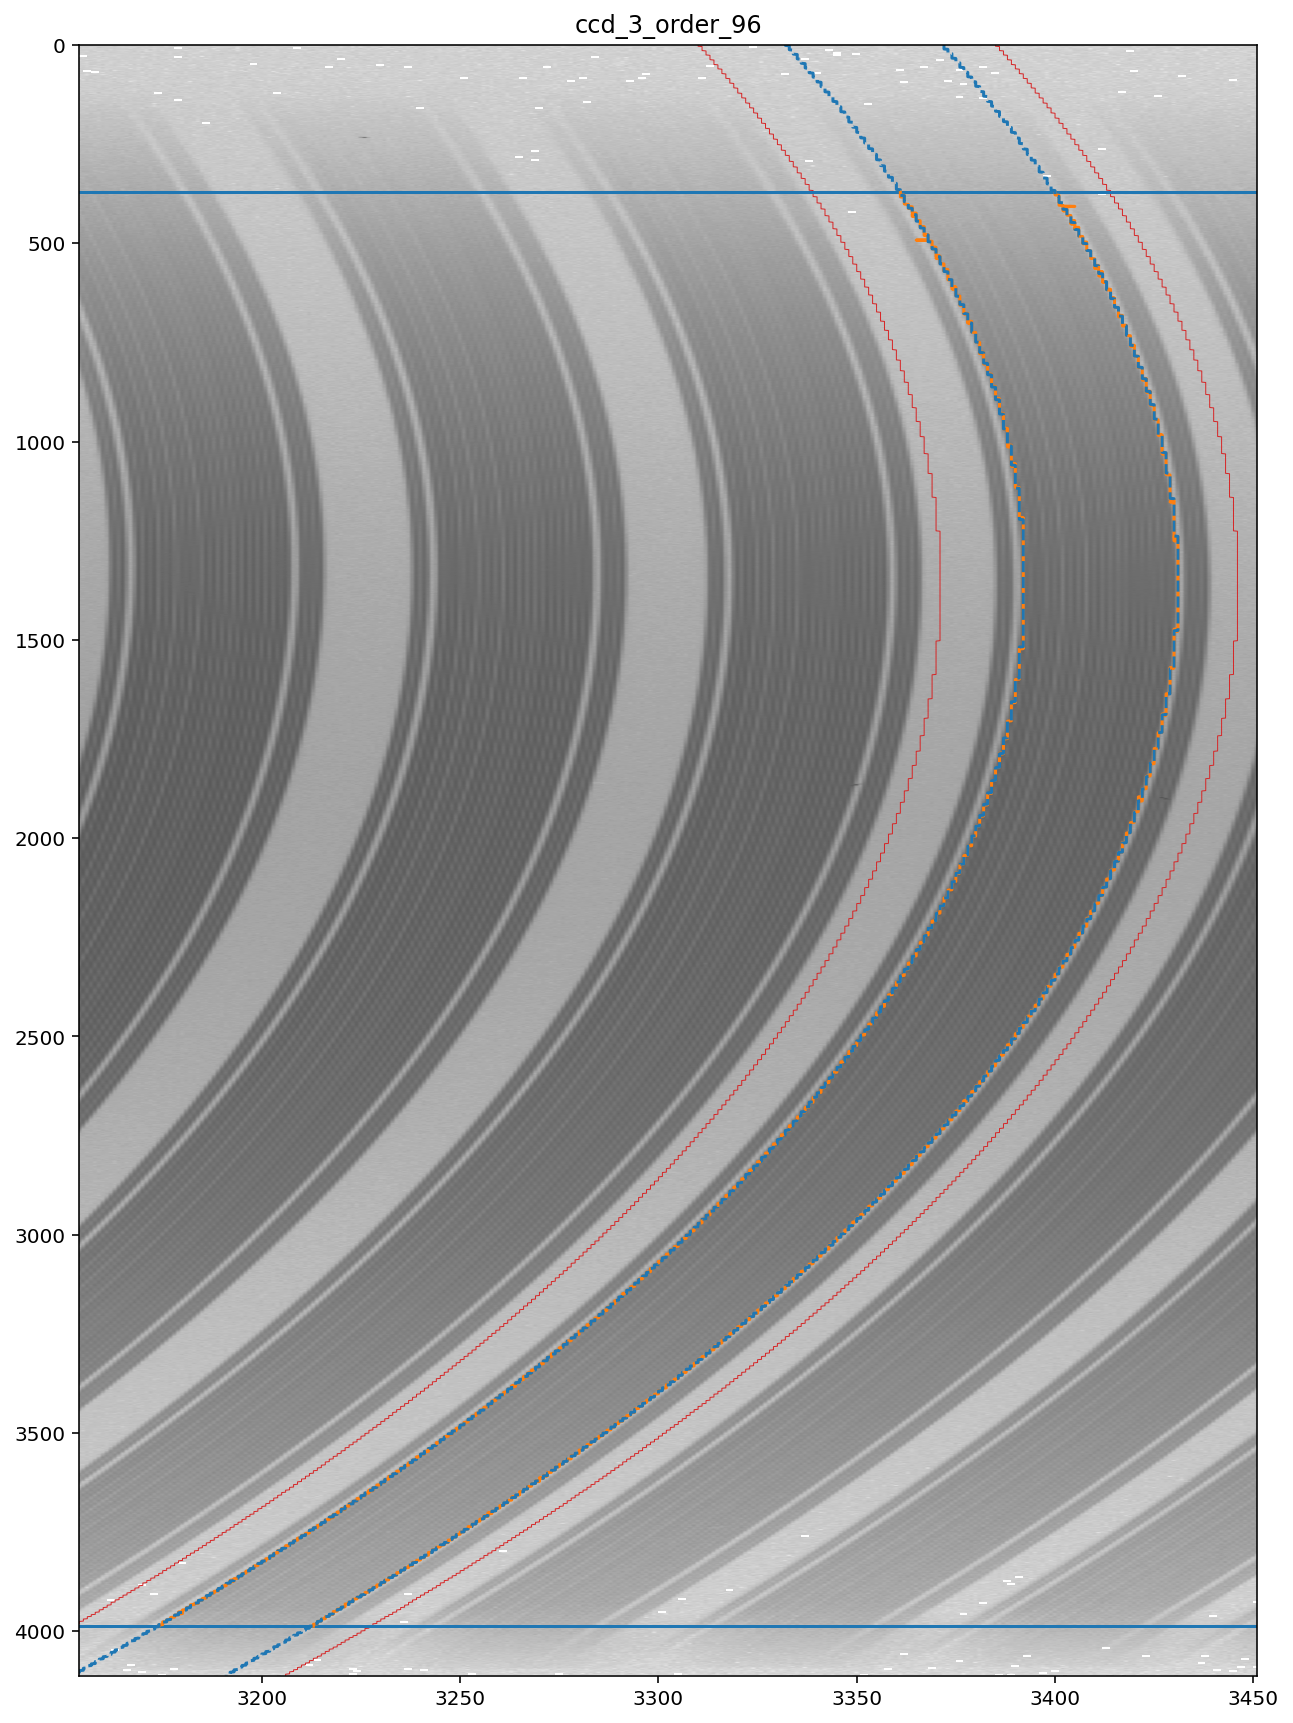

In [14]:
VR.extraction.optimise_tramline_polynomial(
    overscan_subtracted_images = images, 
    order = 'ccd_3_order_96',
    readout_mode = readout_mode
)

In [15]:
np.loadtxt('VeloceReduction/tramline_information/tramlines_begin_end_ccd_3_order_96.txt')

array([[ 3.33236757e+03,  8.98744525e-02, -3.50559445e-05,
         1.21486122e-09, -1.45449906e-13,  3.70000000e+02],
       [ 3.37160133e+03,  8.85545107e-02, -3.40793341e-05,
         9.33694456e-10, -1.17804079e-13,  1.25000000e+02]])